In [20]:
import numpy as np
import wsindy as ws
import ODE_examples
import matplotlib.pylab as plt
import pysindy as ps

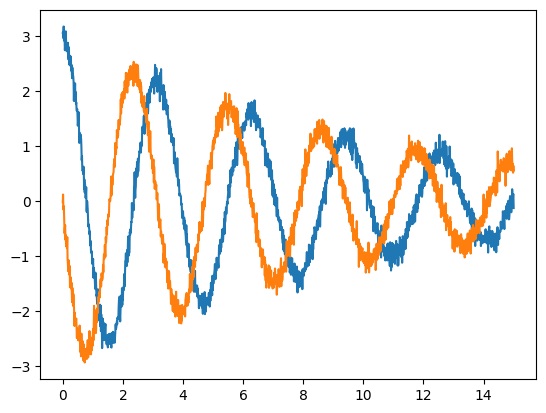

In [21]:
ode_num = 0 # select ODE system from the list ode_names
tol_ode = 1e-15                    # sol_ivp tolerance (abs and rel) for generating data                     
noise_ratio = 0.1  #set signal-to-noise ratio(L2 sense)
np.random.seed(42)                 #reproducibility 
useFD_SINDy = 1                    #SINDy finite difference differentiation order, if 0 uses TVdiff
use_preset_params = True           #Use parameters specified in gen_data

#ode params
ode_names = ['Linear','Logistic_Growth','Van_der_Pol','Duffing','Lotka_Volterra','Lorenz']
ode_name = ode_names[ode_num]

if ode_name == 'Linear':
    ode_params = np.array([[[-0.1, 2], [-2, -0.1]]]) 
    x0 = np.array([3,0]).T
    t_span = np.array([0, 15])
    t_eval = np.linspace(0, 15, 1501)
elif ode_name == 'Logistic_Growth':
    ode_params = np.array([2])
    x0 = np.array([0.01]).T
    t_span = np.array([0, 10])
    t_eval = np.arange(0, 10, 0.005)
elif ode_name == 'Van_der_Pol':
    dt = 0.01
    ode_params = np.array([4])
    x0 = np.array([0,1]).T
    t_span = np.array([0, 30])
    t_eval = np.arange(0, 30, dt)
elif ode_name == 'Duffing':
    mu = 0.2
    ode_params =  np.array([mu, mu**2/4*5,1])
    x0 = np.array([0,2]).T
    t_eval = np.arange(0, 30, 0.01)
    t_span = np.array([0,30])
elif ode_name == 'Lotka_Volterra':
    alpha= 2/3
    beta = 4/3
    ode_params = np.array([alpha, beta,1, 1])
    x0 = np.array([10,10]).T
    t_span = np.array([0, 200])
    t_eval = np.arange(0, 200, 0.02)
elif ode_name == 'Lorenz':
    ode_params = np.array([10, 8/3,27])
    t_span = np.array([0.001, 10])
    t_eval = np.linspace(0.001, 10, 5000)
    x0 = np.array([-8 ,10 ,27]).T
    #x0 = [rand(2,1)*30-15;rand*30+10]
weights, t, xobs, rhs = ODE_examples.simODE(
        x0, t_span, t_eval, tol_ode, ode_name, ode_params, noise_ratio)
plt.plot(t,xobs)

In [22]:
WSINDy_model = ws.wsindy(polys=np.arange(0, 5))

#Uniform
WSINDy_model.getWSindyUniform(xobs, t, L = 30, overlap=0.7)

#Adaptive
#WSINDy_model.getWsindyAdaptive(xobs, t, K = 200)

WSINDy_sim = WSINDy_model.simulate(t_span = np.array([0, 30]), t_eval = np.arange(0, 30, 0.01), x0 = x0)


In [23]:
poly_library = ps.PolynomialLibrary(include_interaction=True, degree = 4)
optimizer = ps.STLSQ( copy_X=False, fit_intercept=False, max_iter=20, ridge_kw=None)

SINDy_model = ps.SINDy(feature_library = poly_library, optimizer = optimizer)
SINDy_model.fit(xobs, t = t)
SINDy_sim = SINDy_model.simulate(x0 = x0, t  = np.arange(0, 30, 0.01))

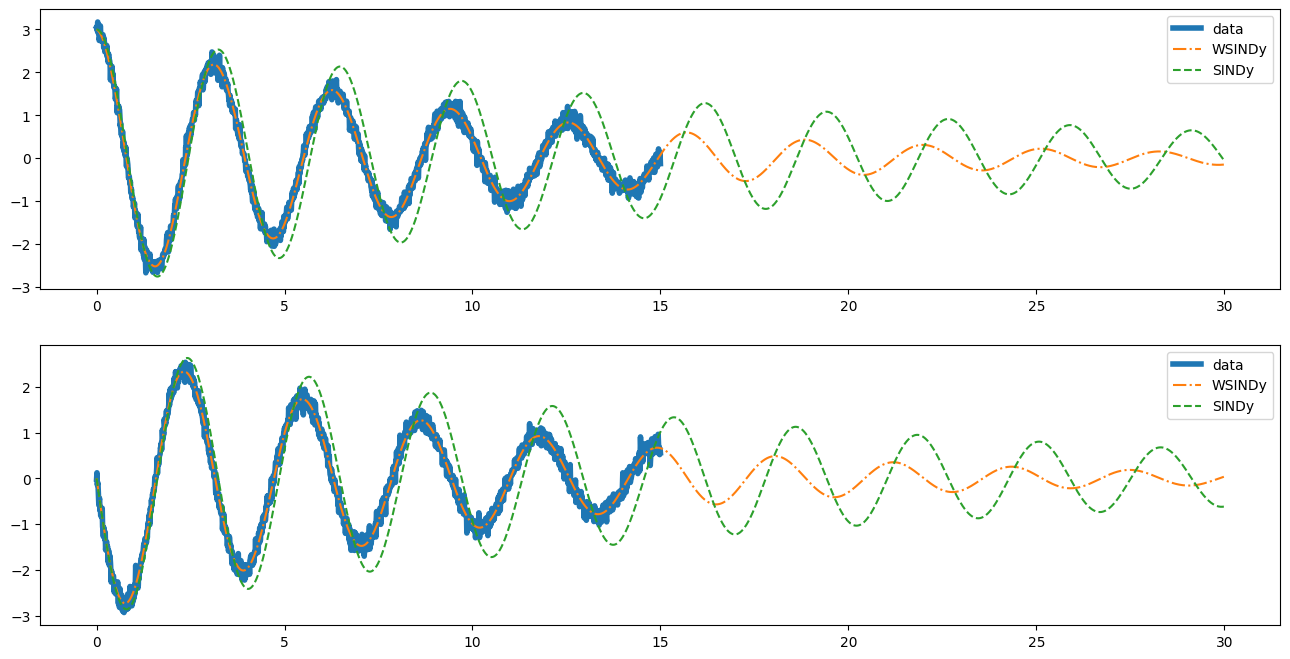

In [24]:
fig = plt.figure(figsize=(16, 8))
c = 1
n = xobs.shape[1]
for d in range(n):
    plt.subplot(n, 1, c)
    plt.plot(t, xobs[:, d], label = "data", linewidth = 4)
    plt.plot(np.arange(0, 30, 0.01), WSINDy_sim[:, d], linestyle='dashdot', label = 'WSINDy') #marker = 'v', markevery = 200)
    plt.plot(np.arange(0, 30, 0.01), SINDy_sim[:, d], "--", label = 'SINDy',) #marker = 'o', markevery=300)
    c = c + 1
    plt.legend()

#plt.legend()

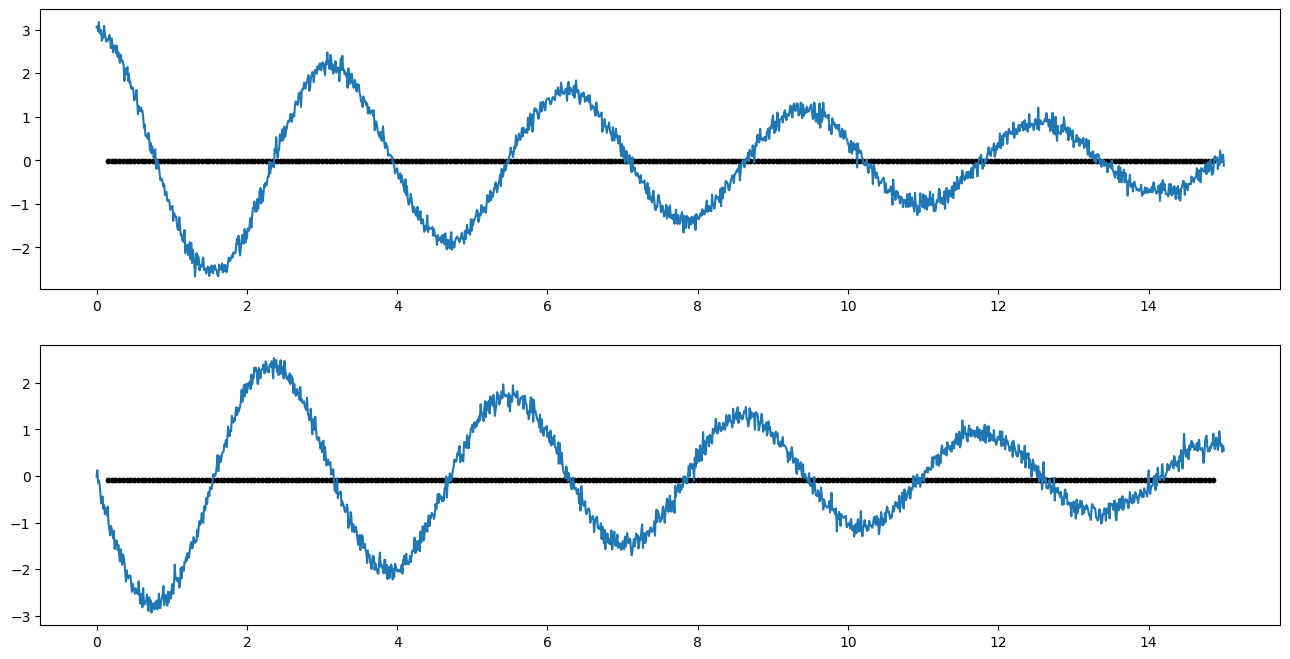

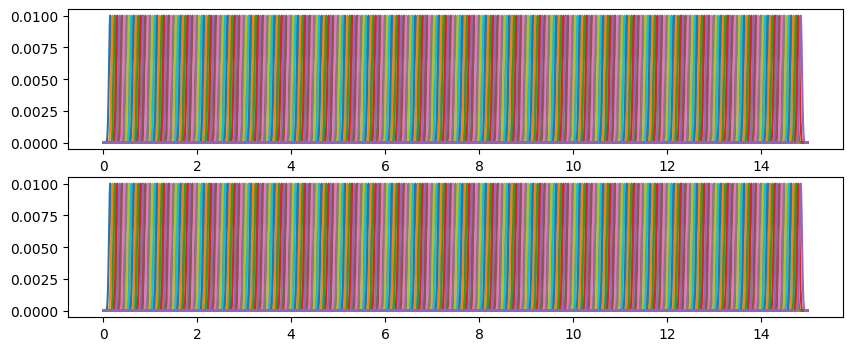

In [25]:
fig = plt.figure(figsize=(16, 8))
c = 1
n = xobs.shape[1]

for d in range(n):
    plt.subplot(n, 1, c)
    temp = np.floor(np.mean(WSINDy_model.ts_grids[d], 1)).astype(int)
    plt.scatter(np.take(t, temp), np.mean(
        xobs[:, d])*np.ones(WSINDy_model.ts_grids[d].shape)[:, 0], s=10, color='black')
    plt.plot(t, xobs[:, d])
    c = c + 1

fig = plt.figure(figsize=(10, 4))
c = 1
for d in range(n):
    plt.subplot(n, 1, c)
    plt.plot(t, WSINDy_model.mats[d][0].T)
    c = c + 1